In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import cv2
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks #
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

#Three Headed Dog Room
couch = {"name": "couch","type": "furniture",}
piano = {"name": "piano","type": "furniture",}
fluffy = {"name": "fluffy", "type": "obstacle",} # door a
flute = {"name": "flute", "type": "key", "target": fluffy,}

#Devil's Snare Room
queen_bed = {"name": "queen bed", "type": "furniture",}
magical_mirror = {"name": "magical mirror", "type": "obstacle"}
plant = {"name": "plant", "type": "obstacle",} # door B
magical_scissors = {"name": "magical scissors", "type": "key", "target": plant,}

#Magical closet
double_bed = {"name": "double bed", "type": "furniture",}
dresser = {"name": "dresser","type": "furniture",}
invisibility_cape = {"name": "invisibility cape", "type": "key", "target": magical_mirror,}

# Door in potion room
potion = {"name": "potion", "type": "obstacle",} # door D
bottle_opener = {"name": "bottle opener", "type": "key", "target": potion}

#Potion room
dining_table = {"name": "dining table", "type": "furniture",}

three_headed_dog_room = {"name": "three headed dog room","type": "room",}
plant_room = {"name": "plant room", "type":"room",}
magical_closet= {"name": "magical closet", "type":"room",}
potion_room = {"name": "potion room", "type":"room",}
outside = {"name": "outside"}


all_rooms = [three_headed_dog_room, plant_room, magical_closet, potion_room, outside]
all_obstacles = [fluffy, plant, magical_mirror, potion ]

# define which items/rooms are related

object_relations = {"three headed dog room": [couch, piano, fluffy],
                    "plant room": [queen_bed, fluffy, plant, magical_mirror],
                    "magical closet": [double_bed, dresser, plant],
                    "potion room": [dining_table, magical_mirror, potion],
                    "outside": [potion],
                    "piano": [flute],
                    "fluffy": [three_headed_dog_room, plant_room],
                    "plant": [plant_room, magical_closet],
                    "queen bed": [magical_scissors],
                    "double bed": [invisibility_cape],
                    "dresser":[bottle_opener],
                    "magical mirror":[plant_room, potion_room],
                    "potion":[potion_room, outside],

}
# define game state. Do not directly change this dict.
# Instead, when a new game starts, make a copy of this
# dict and use the copy to store gameplay state. This
# way you can replay the game multiple times.

game_state = {"current_room": three_headed_dog_room, "keys_collected": [], "target_room": outside}


In [3]:
text_for_room = {"three headed dog room": 
'''
You find yourself in the chamber guarded by the three-headed dog, 
a mystical creature that came into existence at the dawn of time. 
His name is Fluffy and it is hungry for drunk wizards who do not respect magic. 
You will have to prove that you are worthy to go through it and that it was just a bad night, 
as any other wizard celebrating after a victory in the local magic quest.
''',
                 
                 "plant_room" : 
'''
You have now entered the Devil's Snare chamber, a place shrouded in darkness and mystery. 
This room is a part of an ancient odyssey that will guide you through progressively more perilous trials. 
The Devil's Snare, a malevolent and sentient plant, grows thick and treacherous. 
You also have to face the mirrored door, a door that only opens for those that cannot be seen...uhhh spooky.
''',
                 
                 "magical_closet" : 
'''
This room is a pivotal juncture in your adventure, the gateway to the final stage. 
It shall be the place where strategy and cunning will be your greatest allies...
as long if your alcoholic brain is still working!
''',
                 "potion_room" : 
'''
It seems like the end of your journey is coming to a possible end. 
Explore this final stage of your quest and prove you are no longer hungover
''',
                 "outside": 
'''
The magical potion that you so much need is at your grasp. 
And it's water...yeah, it's water for your hangover. Come on..bootle up.
'''
                            }

In [4]:
def linebreak():
    """
    Print a line break
    """
    print("\n\n")

In [5]:
def start_game():
    """
    Start the game
    """

    player_name = input("Hello Wizard. What's your name?")


    image = cv2.imread('drunk_test.jpg', 0)
    plt.imshow(image, 'gray')
    plt.title('''
                Dungeon and Wizards – The Escape Room Game
            The next sensation of interactive gameplay..with Python'''
             )
    plt.axis('off')
    plt.show()

    print(f'''
        Greetings. Rise and shine {player_name}... well, at least attempt to shine.
        It appear's you've drawn a blank on everyting happened after last night's shenanigans.
        Perhaps it is high time to consult with a professional about your little potion-pickling problem...
        You may be wondering what the h* is going on, right? 
        Well, you find yourself trapped in this tower that looks kind of creepy.
        Maybe its a sign to take the game's literally and make a grand ESCAPE!
        '''
    )
    play_room(game_state["current_room"])

In [6]:
def play_room(room):
    """
    Play a room. First check if the room being played is the target room.
    If it is, the game will end with success. Otherwise, let player either
    explore (list all items in this room) or examine an item found here.
    """
    game_state["current_room"] = room
    
    if(game_state["current_room"] == game_state["target_room"]):
        print("Congrats! You escaped the room!")
    
    else:
        print("You are now in " + room["name"])
        intended_action = input("What would you like to do? Type 'explore' or 'examine'?").strip()
        if intended_action == "explore":
            if room["name"] in text_for_room:
                print(text_for_room[room["name"]])
            explore_room(room)
            play_room(room)
        elif intended_action == "examine":
            examine_item(input("What would you like to examine?").strip())
        else:
            print("Not sure what you mean. Type 'explore' or 'examine'.")
            play_room(room)
        linebreak()

In [7]:
def explore_room(room):
    if room["name"] == "three headed dog room":
        image = cv2.imread('three_headed_dog_room.jpg', 0)
        plt.imshow(image, 'gray')
        plt.title('''three headed dog room''')
        plt.axis('off')
        plt.show()
    if room["name"] == "plant room":
        image = cv2.imread('plant_room.jpg', 0)
        plt.imshow(image, 'gray')
        plt.title('''Devil's Snare chamber''')
        plt.axis('off')
        plt.show()
    if room["name"] == "magical closet":
        image = cv2.imread('magical_closet.jpg', 0)
        plt.imshow(image, 'gray')
        plt.title('''Magical Closet''')
        plt.axis('off')
        plt.show()
    if room["name"] == "potion room":
        image = cv2.imread('potion_room.jpg', 0)
        plt.imshow(image, 'gray')
        plt.title('''Potion Room''')
        plt.axis('off')
        plt.show()

        
    """
    Explore a room. List all items belonging to this room.
    """
    items = [i["name"] for i in object_relations[room["name"]]]
    print(f'''You explore the room. This is the {room["name"]}. 
    You find these items particularly suspicious {", ".join(items)}''')

In [8]:
def get_next_room_of_door_and_obstacle(obstacle, current_room): 
    """
    From object_relations, find the two rooms connected to the given door.
    Return the room that is not the current_room.
    """
    connected_rooms = object_relations[obstacle["name"]]
    for room in connected_rooms:
        if(not current_room == room):
            return room
  

In [9]:
def examine_item(item_name):
    """
    Examine an item which can be a  furniture or an obstacle.
    First make sure the intended item belongs to the current room.
    Then check if the item is an obstacle. Tell player if neutralizing items haven't bbeen
    collected yet for obstacle. Otherwise ask player if they want to go to the next
    room. If the item is not an obstacle, then check if it contains keys-items.
    Collect the key-items if found and update the game state. At the end,
    play either the current or the next room depending on the game state
    to keep playing.
    """
    current_room = game_state["current_room"]
    next_room = ""
    output = None

    for item in object_relations[current_room["name"]]:
        if(item["name"] == item_name):
            output = "You examine " + item_name + ". "
            if(item["type"] == "obstacle"):
                have_key = False
                for key in game_state["keys_collected"]:
                    if(key["target"] == item):
                        have_key = True
                if(have_key):
                    output += "You overcome your obstacle successfully by using the item you collected in your search! Not bad for a drunk wizard!"
                    next_room = get_next_room_of_door_and_obstacle(item, current_room)
                else:
                    output += "The magical threat is still looming over you. Find a way to neutralize it!."
            elif(item["type"] == "obstacle"):
                have_key = False
                for key in game_state["keys_collected"]:
                    if(key["target"] == item):
                        have_key = True
                if(have_key):
                    output += "You overcome your obstacle successfully by using the item you collected in your search! Not bad for a drunk wizard!"
                    next_room

            else:
                if(item["name"] in object_relations and len(object_relations[item["name"]])>0):
                    item_found = object_relations[item["name"]].pop()
                    game_state["keys_collected"].append(item_found)
                    output += "You find the enchanted " + item_found["name"] + "."
                else:
                    output += "There isn't anything interesting about it. Looks like you are waisting precious time..."
            print(output)
            break

    if(output is None):
        print("The item you requested is not found in the current room.")

    if(next_room and input("Do you want to go to the next room? Enter 'yes' or 'no'").strip() == 'yes'):
        play_room(next_room)
    else:
        play_room(current_room)

Hello Wizard. What's your name? Jose


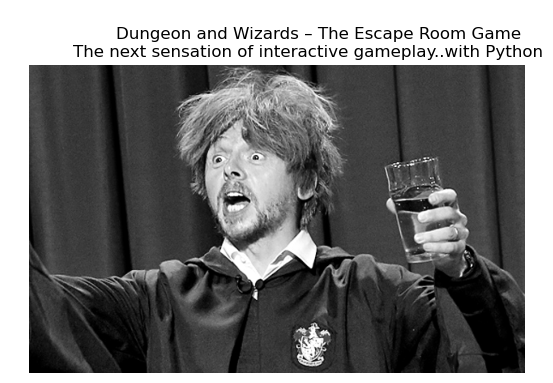


        Greetings. Rise and shine Jose... well, at least attempt to shine.
        It appear's you've drawn a blank on everyting happened after last night's shenanigans.
        Perhaps it is high time to consult with a professional about your little potion-pickling problem...
        You may be wondering what the h* is going on, right? 
        Well, you find yourself trapped in this tower that looks kind of creepy.
        Maybe its a sign to take the game's literally and make a grand ESCAPE!
        
You are now in three headed dog room


What would you like to do? Type 'explore' or 'examine'? explore



You find yourself in the chamber guarded by the three-headed dog, 
a mystical creature that came into existence at the dawn of time. 
His name is Fluffy and it is hungry for drunk wizards who do not respect magic. 
You will have to prove that you are worthy to go through it and that it was just a bad night, 
as any other wizard celebrating after a victory in the local magic quest.



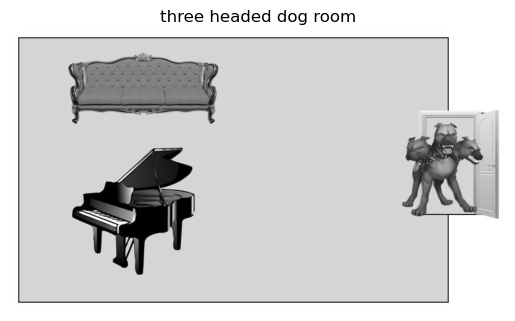

You explore the room. This is the three headed dog room. 
    You find these items particularly suspicious couch, piano, fluffy
You are now in three headed dog room


What would you like to do? Type 'explore' or 'examine'? examine
What would you like to examine? piano


You examine piano. You find the enchanted flute.
You are now in three headed dog room


What would you like to do? Type 'explore' or 'examine'? examine
What would you like to examine? fluffy


You examine fluffy. You overcome your obstacle successfully by using the item you collected in your search! Not bad for a drunk wizard!


Do you want to go to the next room? Enter 'yes' or 'no' yes


You are now in plant room


What would you like to do? Type 'explore' or 'examine'? explore


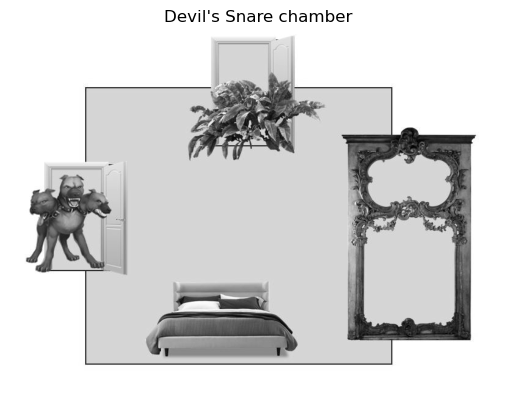

You explore the room. This is the plant room. 
    You find these items particularly suspicious queen bed, fluffy, plant, magical mirror
You are now in plant room


In [ ]:
start_game()